In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.plotting import plot_grid

## Preprocessing Steps

In [2]:
df_location = dl.load_data('pv_data', 'system_location.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [3]:
df_pv.head()

,10003,10004,10005,10048,10049,10063,10064,10082,10086,10131,...,9816,9865,9866,9867,9870,9871,9902,9903,9960,9989
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:05:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:10:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:15:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:20:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:25:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_pv.tail()

,10003,10004,10005,10048,10049,10063,10064,10082,10086,10131,...,9816,9865,9866,9867,9870,9871,9902,9903,9960,9989
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-27 23:35:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2021-10-27 23:40:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2021-10-27 23:45:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2021-10-27 23:50:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2021-10-27 23:55:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [5]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [6]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [7]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [ ]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [15]:
DAY_MIN = 8
DAY_MAX = 16
DAY_INIT = 0
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.35
COORDS = (55, -1.5)

In [2]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [17]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [3]:
df_location.head()
# find row pairs of latitude_rounded and longitude_rounded that are unique
df_location_unique = df_location[['latitude_rounded', 'longitude_rounded']].drop_duplicates()
# save the unique locations on the desktop
dl.save_csv(df_location_unique, 'pv_data', 'unique_locations.csv')

In [18]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

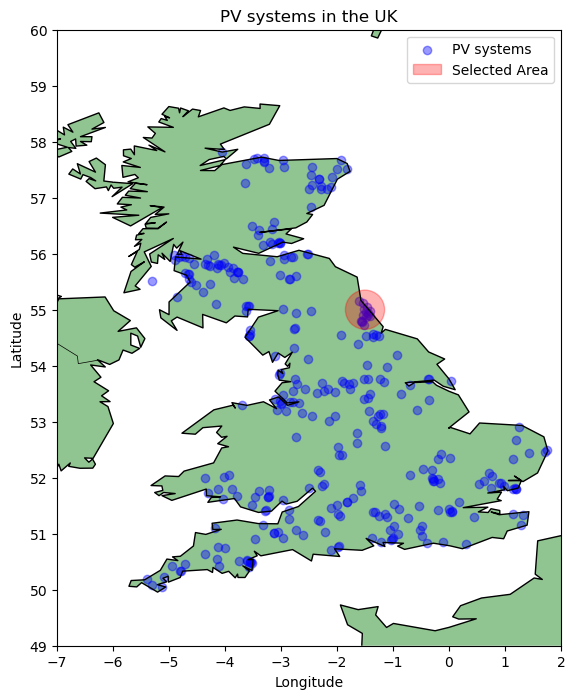

In [19]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [20]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation
==> Loading data
==> Loaded data in: 0 m : 8 sec

/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation
==> Loading data
==> Loaded data in: 0 m : 0 sec



In [21]:
x, y = loader.get_time_series()

In [22]:
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=3)

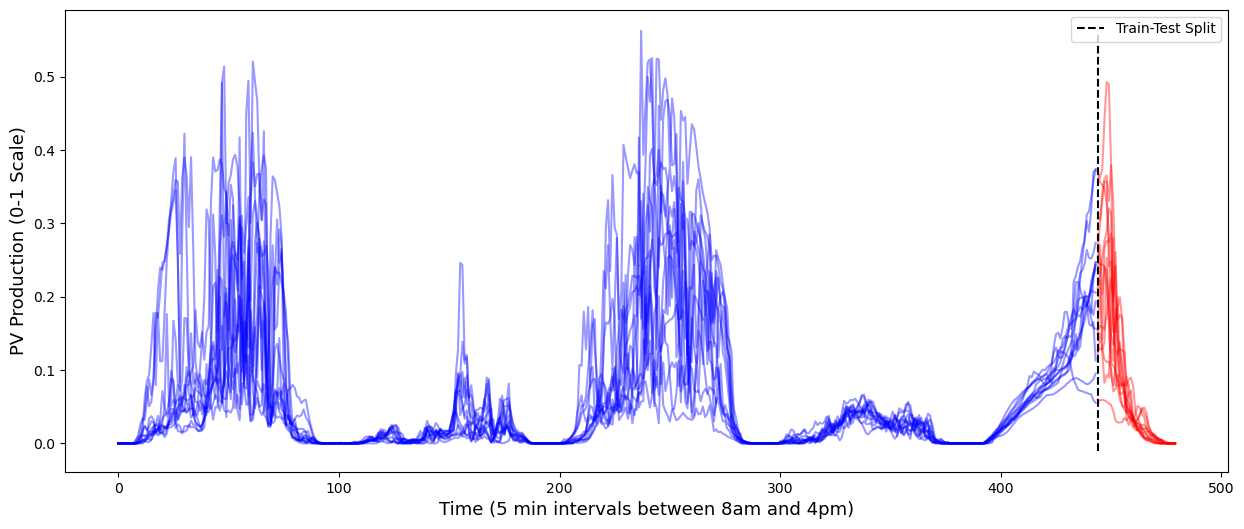

In [24]:
from src.plotting import plot_train_test_split
plot_train_test_split(y_train, y_test)